---
# GeoPandas for Climate Scientists & Meteorologists

- A practical, hands‑on notebook introducing **GeoPandas** and the **geospatial stack** for climate & weather applications.  

You’ll learn how to load and inspect vector data (stations, administrative regions), perform spatial operations (joins, buffers, overlays), manage **CRS** (coordinate reference systems), and integrate with **xarray/rioxarray** to extract/aggregate values from NetCDF (e.g., CHIRPS, ERA5).

**What you’ll need** (install instructions below):
- Python 3.10+
- `geopandas`, `shapely`, `pyproj`, `matplotlib`
- For climate raster work: `xarray`, `rioxarray`, `rasterio`, `regionmask`, `salem`


## Outline: 

- Installing GeoPandas
- Create GeoDataFrame and Inspect 
- Plot GeoDataFrame
- Spatial Operations [Aggregation, Buffering, Dissolving, Overlay]
- Reprojection and CRS Management
- Extract Point  data from NetCDF file
- (Optional) Save sample data to GeoJSON
- Masking NetCDF with Shapefile [salem] 
- Reading and Writing Shapfile/GeoJSON file 

---
## Installing GeoPandas

In [ ]:

# Using conda (recommended for geospatial stack)
# !conda install -c conda-forge geopandas xarray rioxarray rasterio shapely pyproj regionmask matplotlib -y

# Using pip (ensure system has GEOS/PROJ/GDAL preinstalled or use wheels on manylinux)
# !pip install geopandas shapely matplotlib xarray rioxarray rasterio regionmask salem  


In [121]:
# Set working directory 

import os
os.chdir("c:\\Users\\yonas\\Documents\\ICPAC\\python-climate")

processed_data_dir = os.path.join("data", "processed")
raw_data_dir = os.path.join("data", "raw")

---
## Imports & Environment

In [ ]:

import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, box
import matplotlib.pyplot as plt
import xarray as xr
import salem
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [ ]:
# Print GeoPandas version
print(gpd.__version__) 

1.1.1


---
## GeoPandas Fundamentals

- GeoPandas extends pandas with a **geometry** column (typically `shapely` geometries) and **CRS** metadata.

- It supports typical table operations (filter, groupby) plus spatial operations (buffer, intersection).


---
## Create sample data (stations & regions) for Ethiopia

- We’ll synthesize **station points** and **region polygons** roughly within Ethiopia’s bounds to avoid external downloads.


In [8]:
#  Define Ethiopia bounding box
ethi_bbox = box(33, 3, 48, 15)

# Create GeoDataFrame for 3 regions: North, Center, South Ethiopia
regions = gpd.GeoDataFrame(
    {
        "region": ["North", "Center", "South"],
        "geometry": [
            box(36, 11, 44, 15),  # North
            box(36, 7,  44, 11),  # Center
            box(36, 3,  44, 7),   # South
        ],
    },
    crs="EPSG:4326"
)

---
## Inspect the dataframe 

In [9]:
# Display stations and regions
regions

,region,geometry
0,North,"POLYGON ((44 11, 44 15, 36 15, 36 11, 44 11))"
1,Center,"POLYGON ((44 7, 44 11, 36 11, 36 7, 44 7))"
2,South,"POLYGON ((44 3, 44 7, 36 7, 36 3, 44 3))"


In [10]:
regions.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
# Get bounding box of all regions
regions.geometry.total_bounds  # minx, miny, maxx, maxy

array([36.,  3., 44., 15.])

In [ ]:
#  Print columns of regions GeoDataFrame
print("Regions columns:", regions.columns.tolist())


Regions columns: ['region', 'geometry']


<Axes: >

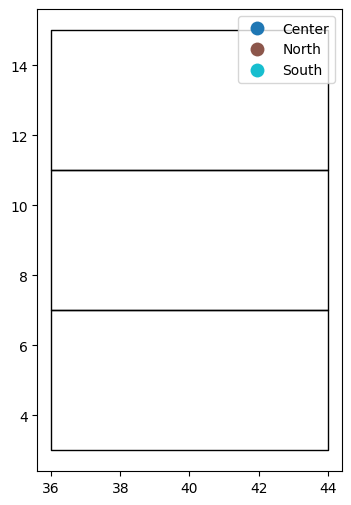

In [ ]:
# Basic plot of bounding box 
regions.plot( figsize=(12, 6),
             edgecolor='black', 
             facecolor='none',
             column='region',
             legend=True,      
             )

In [21]:
# Create GeoDataFrame for some weather stations in Ethiopia 
station_records = [
    {"station_id": "STA001", "lon": 37.5, "lat": 13.2, "elev_m": 2500},
    {"station_id": "STA002", "lon": 38.3, "lat": 10.2, "elev_m": 2100},
    {"station_id": "STA003", "lon": 39.5, "lat": 6.2,  "elev_m": 1500},
    {"station_id": "STA004", "lon": 42.0, "lat": 8.8,  "elev_m": 1800},
]

# Create DataFrame for station records
df = pd.DataFrame(station_records)

# Convert to GeoDataFrame with geometry column
gdf_stn = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["lon"], df["lat"]),
    crs="EPSG:4326",
)

---
## Data Loading & Inspection

In [7]:
regions.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [22]:
gdf_stn.head()

,station_id,lon,lat,elev_m,geometry
0,STA001,37.5,13.2,2500,POINT (37.5 13.2)
1,STA002,38.3,10.2,2100,POINT (38.3 10.2)
2,STA003,39.5,6.2,1500,POINT (39.5 6.2)
3,STA004,42.0,8.8,1800,POINT (42 8.8)


<Axes: >

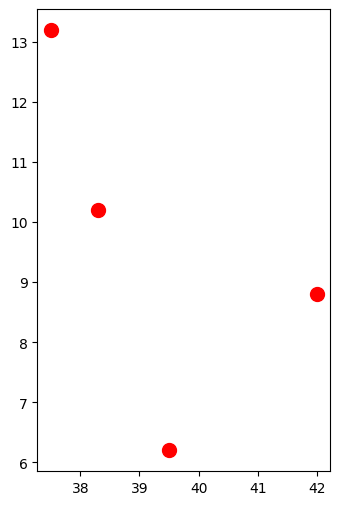

In [26]:
gdf_stn.plot(figsize=(10, 6), 
             color='red', 
             markersize=100,
             legend=True,
                )

---

## Plot stations over regions

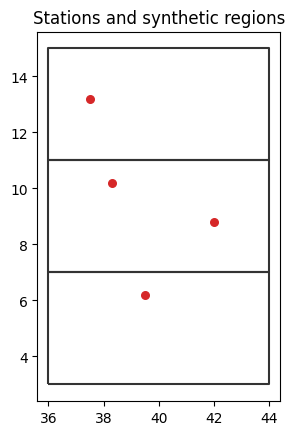

In [ ]:
# Plot stations over regions 

ax = regions.boundary.plot(edgecolor="0.2")
gdf_stn.plot(ax=ax, color="tab:red", markersize=30)
ax.set_title("Stations and synthetic regions")
plt.show()


---

## Basic plotting with `.plot()`

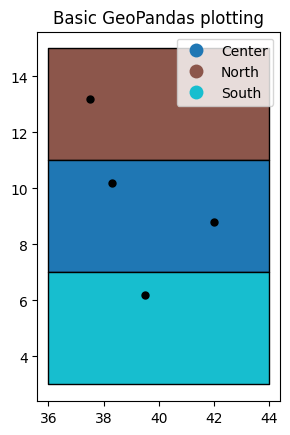

In [33]:

ax = regions.plot(column="region", legend=True, edgecolor="k")
gdf_stn.plot(ax=ax, color="black", markersize=25)
ax.set_title("Basic GeoPandas plotting")
plt.show()


---
## Spatial Operations
### Spatial Join: map stations to regions


In [ ]:
# Spatial join: Find which stations fall within which regions 
stn_in_regions = gpd.sjoin(gdf_stn, 
                           regions, 
                           how="left", 
                           predicate="within") # or "intersects", 
# Select relevant columns 
stn_in_regions[["station_id","region","elev_m","geometry"]]
# Print the resulting GeoDataFrame
stn_in_regions


,station_id,lon,lat,elev_m,geometry,index_right,region
0,STA001,37.5,13.2,2500,POINT (37.5 13.2),0,North
1,STA002,38.3,10.2,2100,POINT (38.3 10.2),1,Center
2,STA003,39.5,6.2,1500,POINT (39.5 6.2),2,South
3,STA004,42.0,8.8,1800,POINT (42 8.8),1,Center


---
### Aggregation by region (example)

In [ ]:
# Compute average elevation of stations per region 
agg = stn_in_regions.groupby("region", dropna=False)["elev_m"].mean().reset_index(name="avg_elev_m")
agg


,region,avg_elev_m
0,Center,1950.0
1,North,2500.0
2,South,1500.0


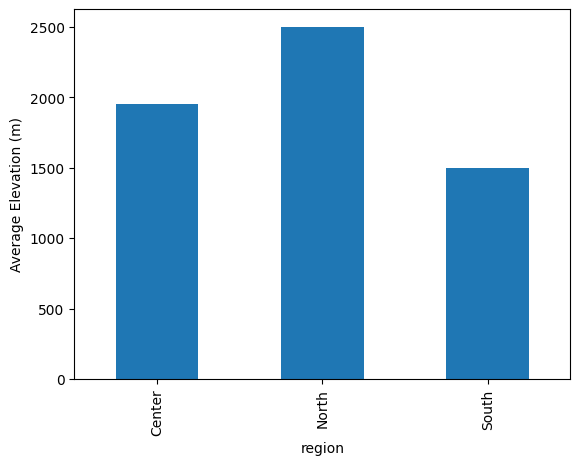

In [37]:
# Plot average elevation per region
agg.plot.bar(x="region", y="avg_elev_m", legend=False)
plt.ylabel("Average Elevation (m)")
plt.show()


---
### Buffering (e.g., 50 km around stations): use a projected CRS in meters


In [38]:
#  convert to projected CRS in meters (UTM zone 37N) 
stn_utm = gdf_stn.to_crs("EPSG:32637")

# copy the GeoDataFrame 
buf50 = stn_utm.copy()

# Create 50 km buffers around each station
buf50["geometry"] = stn_utm.buffer(50_000)  # 50 km

# Convert buffers back to WGS84 for plotting
buf50_wgs84 = buf50.to_crs("EPSG:4326")


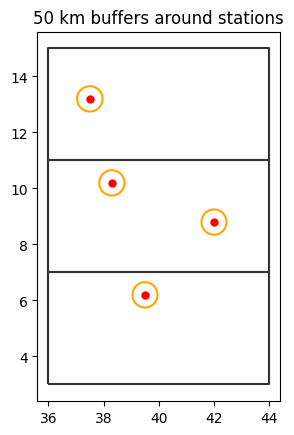

In [ ]:
# Plot buffers around stations 
ax = regions.boundary.plot(edgecolor="0.2")
buf50_wgs84.boundary.plot(ax=ax, color="orange")
gdf_stn.plot(ax=ax, color="red", markersize=25)
ax.set_title("50 km buffers around stations")
plt.show()

---
### Dissolving polygons by attribute

In [ ]:

# Dissolve regions by "region" column (no effect here since already unique)
regions_dissolved = regions.dissolve(by="region")

regions_dissolved


,geometry
region,
Center,"POLYGON ((44 7, 44 11, 36 11, 36 7, 44 7))"
North,"POLYGON ((44 11, 44 15, 36 15, 36 11, 44 11))"
South,"POLYGON ((44 3, 44 7, 36 7, 36 3, 44 3))"


### Overlay: intersection

In [45]:
#  Select the north region
north = regions.query("region == 'North'")

# Convert to projected CRS in meters (UTM zone 37N)
north_utm = north.to_crs("EPSG:32637")

buf50_utm = buf50  # already EPSG:32637

# Perform intersection between buffers and north region
inter = gpd.overlay(buf50_utm, north_utm, how="intersection")

# Calculate area in square kilometers 
inter["area_km2"] = inter.area / 1e6

# Show relevant columns 
inter[["station_id","region","area_km2"]]

inter


,station_id,lon,lat,elev_m,region,geometry,area_km2
0,STA001,37.5,13.2,2500,North,"POLYGON ((387211.687 1454838.236, 386491.715 1...",7841.371226


---
## Reprojection and CRS Management
- Check CRS: `.crs`
- Define CRS if missing: `.set_crs('EPSG:4326', inplace=True)`
- Transform: `.to_crs('EPSG:32637')`


In [46]:
print("Stations CRS:", gdf_stn.crs)

Stations CRS: EPSG:4326


In [47]:
print("Stations UTM CRS:", stn_utm.crs)

Stations UTM CRS: EPSG:32637


---
## Extract Point  data from NetCDF file




### One timestep for all stations

In [ ]:
# Choose the DataArray 
da = ds["precip"]

# pick one time step (latest here)
da = da.isel(time=-1)  

# Determine the CRS of the raster/grid and pass it to the grid_crs variable
grid_crs = getattr(da.rio, "crs", None) or getattr(ds.rio, "crs", None) or "EPSG:4326"

# Reproject stations to the grid CRS
stn = gdf_stn.to_crs(grid_crs)

# Use the correct spatial coord names from the grid or raster 
x_name = "x"
y_name = "y"

# Extract the lon/lat or x/y values from station geometries
xs = xr.DataArray(stn.geometry.x.values, dims="points")
ys = xr.DataArray(stn.geometry.y.values, dims="points")

# Extract the values at station points from the dataset
vals = da.sel({x_name: xs, y_name: ys}, method="nearest")

# Attach values back to GeoDataFrame 
out = stn.copy()
out["value"] = vals.values
out.head()


,station_id,lon,lat,elev_m,geometry,value
0,STA001,37.5,13.2,2500,POINT (37.5 13.2),6.593847
1,STA002,38.3,10.2,2100,POINT (38.3 10.2),5.579750
2,STA003,39.5,6.2,1500,POINT (39.5 6.2),4.485852
3,STA004,42.0,8.8,1800,POINT (42 8.8),2.406737


---
### Extract the time series for one station 

In [ ]:
# Select a specific station (e.g., the first station)
station = gdf_stn.iloc[0]

# Extract the longitude and latitude of the station
lon = station.geometry.x
lat = station.geometry.y

# Extract the time series of precipitation data for the station
station_timeseries = ds["precip"].sel(x=lon, y=lat, method="nearest")

# Print the time series
station_timeseries


<xarray.DataArray 'precip' (time: 366)> Size: 3kB
array([ 8.90118385,  0.09824973,  9.84963881, 13.83217302,  4.82701112,
        3.02796085,  8.96099998,  0.95233107,  0.75084645,  0.90436388,
        5.74201964, 12.19744575, 20.36288197, 10.75139477,  3.28321376,
       17.41700677,  0.69764574, 15.74290292,  5.32697186,  3.15239653,
        9.84549182,  0.87593684,  8.01575844,  0.62819937,  5.59384104,
       12.14868406, 13.45459792, 18.11698855,  3.35912622,  3.72355798,
        5.03606898,  3.49338772, 12.95855409,  6.68114097,  7.4993605 ,
        8.3016419 ,  6.56083993,  2.40272902,  5.80579683,  9.99313429,
       15.82951358,  5.63553899,  2.18377796,  6.39631524, 16.71267785,
       11.76186451,  3.78251815,  1.67570394,  6.95784883, 15.35415267,
        3.77168257,  8.81742417,  8.53823945, 11.86166171, 11.40575333,
        1.64856121, 11.28622488,  5.83712258,  8.11210692,  1.27081348,
       16.54482488,  5.02891885,  2.49685149,  6.83131134,  6.57492208,
        2.25561692,  5.83733167, 12.02462412,  0.59350707, 27.85619701,
        0.9008682 , 10.48115929,  1.02154927,  5.90818961,  6.17478874,
       10.69234801, 10.61678972,  2.68351046, 17.6276772 ,  0.90080039,
        6.56512981,  5.40134233,  5.09189985,  8.36083916,  8.98695107,
        5.38177287,  1.50759598,  4.10376271, 27.96360062,  0.76229859,
        2.06080187,  4.10987403, 10.47795987,  4.9888542 ,  3.28217836,
       18.61593369,  8.18417935, 11.56894743,  6.08130478,  8.89417778,
...
        0.4699834 ,  3.15634966,  7.33356107,  7.12675824,  2.86563534,
        1.5205371 ,  7.42236143,  7.58697843, 22.52864212,  9.03096085,
        2.66926489, 15.64574595, 10.92660135, 11.62142626,  1.00915691,
       13.39591533, 10.3446771 ,  3.46757717,  2.01734248,  7.40245163,
        6.29116874,  2.3559016 ,  7.39040017, 16.80829489,  1.15275807,
       11.55917206,  4.85304436,  3.4175703 ,  2.51960312,  3.45029352,
        5.5147619 ,  2.05643934, 10.74473374,  4.42487023,  4.43166259,
        7.44804919, 15.9133309 , 14.3350987 ,  6.68431506,  0.94000862,
        1.37526922,  1.12974576,  8.12820603,  7.82927427, 16.11663327,
        3.03036053,  8.35559638,  9.82348928,  4.57551529,  7.89555544,
       17.4869349 ,  2.21683835,  5.36261982,  6.6627613 , 19.50267987,
        5.69839464, 25.87832717, 10.71372776,  1.10604522,  7.67118114,
        4.93233254,  3.32011665, 11.89581228,  6.08836126,  3.68824626,
        1.6512861 ,  4.26023167,  2.41110457,  2.65326915, 16.21881174,
        4.80258245,  8.27956227,  1.87075244, 12.61458757,  2.71844599,
        3.95416159,  7.533296  ,  5.13412516,  2.76724244,  7.7035626 ,
        7.18841443, 22.64938164, 17.08308499,  4.94037975,  8.3034956 ,
        7.84506904,  9.61600142, 16.80952201,  2.29957239, 10.01720154,
       13.90717451, 12.14652   ,  0.49778973,  3.61119683,  7.01184302,
        6.59384701])
Coordinates:
  * time         (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31
    y            float64 8B 13.25
    x            float64 8B 37.5
    spatial_ref  int64 8B 0
Attributes:
    units:    mm/day

In [116]:
station_timeseries_pd = station_timeseries.to_series()
station_timeseries_pd

time
2020-01-01     8.901184
2020-01-02     0.098250
2020-01-03     9.849639
2020-01-04    13.832173
2020-01-05     4.827011
                ...    
2020-12-27    12.146520
2020-12-28     0.497790
2020-12-29     3.611197
2020-12-30     7.011843
2020-12-31     6.593847
Freq: D, Name: precip, Length: 366, dtype: float64

In [ ]:
# export to CSV dataframe
# station_timeseries_pd.to_csv(f"{processed_data_dir}/station_timeseries.csv", header=True)


---
### Extract the time series for mutiple station 

In [117]:
# Create an empty dictionary to store the time series for each station
station_timeseries = {}

# Iterate over each station in the GeoDataFrame
for index, station in gdf_stn.iterrows():
    # Extract the longitude and latitude of the station
    lon = station.geometry.x
    lat = station.geometry.y

    # Extract the time series of precipitation data for the station
    try:
        ts = ds["precip"].sel(x=lon, y=lat, method="nearest")
        # Store as pandas Series
        # Now station_timeseries is a dictionary where the keys are station IDs
        station_timeseries[station["station_id"]] = ts.to_series()  
    except KeyError as e:
        print(f"Error extracting data for station {station['station_id']}: {e}")
        station_timeseries[station["station_id"]] = None 

In [118]:
station_timeseries


{'STA001': time
 2020-01-01     8.901184
 2020-01-02     0.098250
 2020-01-03     9.849639
 2020-01-04    13.832173
 2020-01-05     4.827011
                 ...    
 2020-12-27    12.146520
 2020-12-28     0.497790
 2020-12-29     3.611197
 2020-12-30     7.011843
 2020-12-31     6.593847
 Freq: D, Name: precip, Length: 366, dtype: float64,
 'STA002': time
 2020-01-01     9.459547
 2020-01-02     0.704595
 2020-01-03     4.459861
 2020-01-04     4.469626
 2020-01-05    13.787346
                 ...    
 2020-12-27    10.400662
 2020-12-28     3.188982
 2020-12-29     0.771026
 2020-12-30     3.625833
 2020-12-31     5.579750
 Freq: D, Name: precip, Length: 366, dtype: float64,
 'STA003': time
 2020-01-01     5.355205
 2020-01-02     0.855645
 2020-01-03     1.000385
 2020-01-04     1.277393
 2020-01-05    25.535552
                 ...    
 2020-12-27     9.396427
 2020-12-28     5.579716
 2020-12-29     3.140024
 2020-12-30     4.106899
 2020-12-31     4.485852
 Freq: D, Name: preci

In [122]:
# Export all time series to separate CSV files
for station_id, ts in station_timeseries.items():
    if ts is not None:
        ts.to_csv(
            f"{processed_data_dir}/{station_id}_timeseries.csv", header=True)
        print(f"Exported time series for station {station_id} to {station_id}_timeseries.csv")
    else:
        print(f"No time series data for station {station_id} to export.")

Exported time series for station STA001 to STA001_timeseries.csv
Exported time series for station STA002 to STA002_timeseries.csv
Exported time series for station STA003 to STA003_timeseries.csv
Exported time series for station STA004 to STA004_timeseries.csv


---

## (Optional) Save sample data to GeoJSON

In [125]:

# Export stations and regions to GeoJSON files
stations_fp = f"{processed_data_dir}/stations_demo.geojson"
regions_fp  = f"{processed_data_dir}/regions_demo.geojson"

# Export GeoDataFrames to GeoJSON files
gdf_stn.to_file(stations_fp, driver="GeoJSON")
regions.to_file(regions_fp, driver="GeoJSON")

print("Wrote:", stations_fp, "and", regions_fp)


Wrote: data\processed/stations_demo.geojson and data\processed/regions_demo.geojson


---
### Reading the Geojson file 

In [126]:
# reading the Geojson file stations_demo.geojson file 

gdf_stn_loaded = gpd.read_file(processed_data_dir + "/stations_demo.geojson")   
gdf_stn_loaded.head()

,station_id,lon,lat,elev_m,geometry
0,STA001,37.5,13.2,2500,POINT (37.5 13.2)
1,STA002,38.3,10.2,2100,POINT (38.3 10.2)
2,STA003,39.5,6.2,1500,POINT (39.5 6.2)
3,STA004,42.0,8.8,1800,POINT (42 8.8)


---
### Exporing as Shapefile

In [ ]:
# exporting as Shapefile 

gdf_stn_loaded.to_file(f"{processed_data_dir}/stations_demo.shp", driver="ESRI Shapefile")


---
### Load the Shapefile


In [130]:
gha = gpd.read_file(raw_data_dir + "/shapefile/gha_region_icpac_2016/GHA.shp")

gha 

,OBJECTID,COUNTRY,area,Shape_Leng,Shape_Area,land_under,geometry
0,1,Burundi,0.0,8.560371,2.193095,None,"POLYGON ((30.36003 -2.35343, 30.36209 -2.3525,..."
1,2,Djibouti,0.0,7.874779,1.781569,None,"POLYGON ((42.66339 11.0715, 42.65628 11.07671,..."
2,3,Eritrea,0.0,41.125347,10.077064,None,"MULTIPOLYGON (((43.14681 12.71384, 43.14167 12..."
3,4,Ethiopia,0.0,49.028874,92.986294,None,"POLYGON ((41.77824 11.54207, 41.77785 11.51077..."
4,5,Kenya,0.0,40.625985,47.319578,None,"MULTIPOLYGON (((39.40283 -4.65471, 39.40523 -4..."
5,6,Rwanda,0.0,8.078222,2.054446,None,"POLYGON ((30.3675 -2.34399, 30.36209 -2.3525, ..."
6,7,Somalia,0.0,53.331305,51.800944,None,"MULTIPOLYGON (((41.9267 -1.16192, 41.9226 -1.1..."
7,8,Tanzania,0.0,57.988209,77.546629,None,"MULTIPOLYGON (((40.42789 -10.38034, 40.42349 -..."
8,9,South Sudan,0.0,46.515148,51.867644,None,"POLYGON ((31.79577 3.82198, 31.79585 3.82126, ..."
9,10,Sudan,0.0,73.448957,158.194024,930459.06\r\n930459,"POLYGON ((24.32633 16.51445, 23.99918 16.50046..."


In [141]:
gha[3:5]

,OBJECTID,COUNTRY,area,Shape_Leng,Shape_Area,land_under,geometry
3,4,Ethiopia,0.0,49.028874,92.986294,None,"POLYGON ((41.77824 11.54207, 41.77785 11.51077..."
4,5,Kenya,0.0,40.625985,47.319578,None,"MULTIPOLYGON (((39.40283 -4.65471, 39.40523 -4..."


In [ ]:
# Check the shape of the GeoDataFrame
gha.shape

(11, 7)

In [ ]:
# Check the coordinate reference system (CRS) of the GeoDataFrame
gha.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [132]:
# Get bounding box of all regions
gha.geometry.total_bounds  # minx, miny, maxx, maxy

array([ 21.838947  , -11.7457    ,  51.41303253,  23.14286   ])

In [134]:
# Columns of the GeoDataFrame
gha.columns.tolist()

['OBJECTID',
 'COUNTRY',
 'area',
 'Shape_Leng',
 'Shape_Area',
 'land_under',
 'geometry']

In [ ]:
# Values of the COUNTRY column
gha.COUNTRY.values

array(['Burundi', 'Djibouti', 'Eritrea', 'Ethiopia', 'Kenya', 'Rwanda',
       'Somalia', 'Tanzania', 'South Sudan', 'Sudan', 'Uganda'],
      dtype=object)

In [152]:
# Check the geometry of the GeoDataFrame
gha.geometry

0     POLYGON ((30.36003 -2.35343, 30.36209 -2.3525,...
1     POLYGON ((42.66339 11.0715, 42.65628 11.07671,...
2     MULTIPOLYGON (((43.14681 12.71384, 43.14167 12...
3     POLYGON ((41.77824 11.54207, 41.77785 11.51077...
4     MULTIPOLYGON (((39.40283 -4.65471, 39.40523 -4...
5     POLYGON ((30.3675 -2.34399, 30.36209 -2.3525, ...
6     MULTIPOLYGON (((41.9267 -1.16192, 41.9226 -1.1...
7     MULTIPOLYGON (((40.42789 -10.38034, 40.42349 -...
8     POLYGON ((31.79577 3.82198, 31.79585 3.82126, ...
9     POLYGON ((24.32633 16.51445, 23.99918 16.50046...
10    POLYGON ((32.75026 -0.99732, 32.40119 -0.99728...
Name: geometry, dtype: geometry

In [ ]:
# access the geometry of the GeoDataFrame  one row value
# gha.geometry.iloc[0].wkt

'POLYGON ((30.36003000000005 -2.353429999999946, 30.362090000000023 -2.3524999999999636, 30.367500000000064 -2.3439899999999625, 30.373610000000042 -2.3343999999999596, 30.37895000000003 -2.3210999999999444, 30.382490000000075 -2.3168999999999755, 30.39336000000003 -2.310549999999978, 30.399010000000033 -2.3101199999999267, 30.404870000000074 -2.312339999999949, 30.40769000000006 -2.3155799999999545, 30.415520000000072 -2.324549999999931, 30.422900000000027 -2.3286599999999567, 30.430440000000033 -2.328589999999963, 30.44037000000003 -2.322619999999972, 30.44467000000003 -2.3220999999999776, 30.45053000000007 -2.321399999999926, 30.451860000000067 -2.3227099999999723, 30.45007000000004 -2.3335199999999645, 30.45106000000004 -2.338619999999935, 30.455260000000067 -2.3452199999999266, 30.45867000000004 -2.3476499999999305, 30.463500000000067 -2.3608599999999456, 30.478860000000054 -2.372079999999926, 30.485650000000078 -2.3737199999999348, 30.49890000000005 -2.3806099999999333, 30.511080

---
### Access the geometry of the polygon

In [ ]:
# access the geometry type of the GeoDataFrame 
gha.geom_type


0          Polygon
1          Polygon
2     MultiPolygon
3          Polygon
4     MultiPolygon
5          Polygon
6     MultiPolygon
7     MultiPolygon
8          Polygon
9          Polygon
10         Polygon
dtype: object

In [160]:
def coord_lister(geom):
    if geom.geom_type == 'Polygon':
        coords = list(geom.exterior.coords)
    elif geom.geom_type == 'MultiPolygon':
        coords = []
        for polygon in geom.geoms:
            coords.extend(list(polygon.exterior.coords))
    else:
        return None  # Or raise an exception, depending on your needs
    return coords

coordinates = gha.geometry.apply(coord_lister)
Burundi_coord = coordinates[1]

Burundi_coord

[(42.66339000000005, 11.071500000000071),
 (42.65628000000004, 11.076710000000048),
 (42.655950000000075, 11.077350000000024),
 (42.61602000000005, 11.076080000000047),
 (42.61346000000003, 11.076000000000022),
 (42.58200000000005, 11.070470000000057),
 (42.53864000000004, 11.057590000000062),
 (42.51484000000005, 11.042910000000063),
 (42.477550000000065, 11.035110000000032),
 (42.44233000000003, 11.018670000000043),
 (42.40759000000003, 11.007810000000063),
 (42.33676000000003, 11.00311000000005),
 (42.32669000000004, 11.003150000000062),
 (42.241010000000074, 11.003530000000069),
 (42.189500000000066, 10.994220000000041),
 (42.12985000000003, 10.98849000000007),
 (42.08161000000007, 10.984510000000057),
 (42.03777000000008, 10.966050000000052),
 (41.97532000000007, 10.96058000000005),
 (41.90728000000007, 10.955610000000036),
 (41.83618000000007, 10.980480000000057),
 (41.83203000000003, 10.97207000000003),
 (41.827240000000074, 10.959160000000054),
 (41.815990000000056, 10.95938000

### Ploting the Polygon 

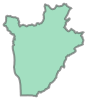

In [161]:
gha.at[0,'geometry']

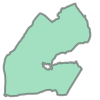

In [162]:
gha.at[1,'geometry']

---
### Plot Greater Horn of Africa regions


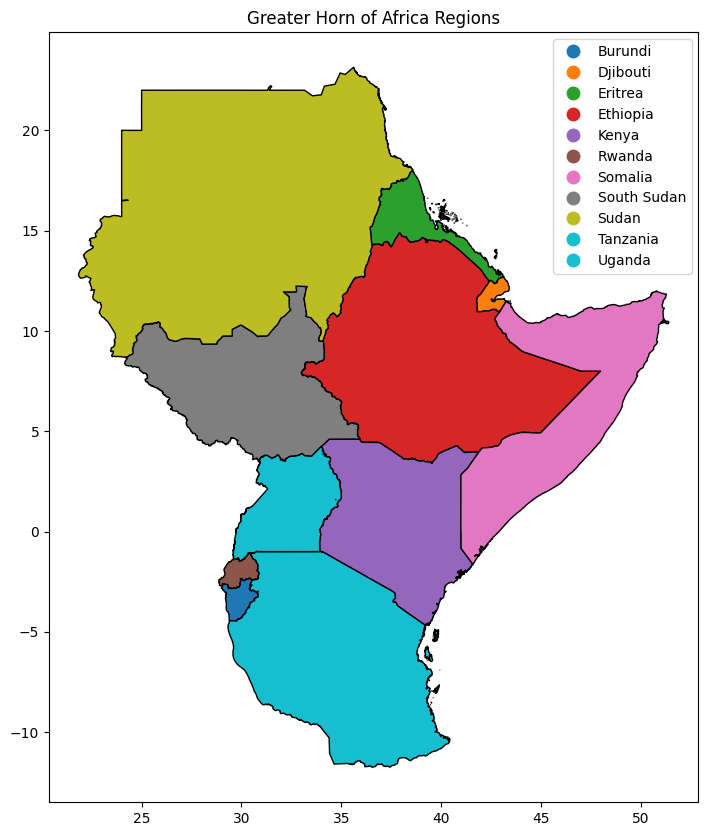

In [ ]:
# Plot Greater Horn of Africa regions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gha.plot(column="COUNTRY", 
         legend=True, 
         edgecolor="k", 
         ax=ax,
         )
ax.set_title("Greater Horn of Africa Regions")
plt.show()

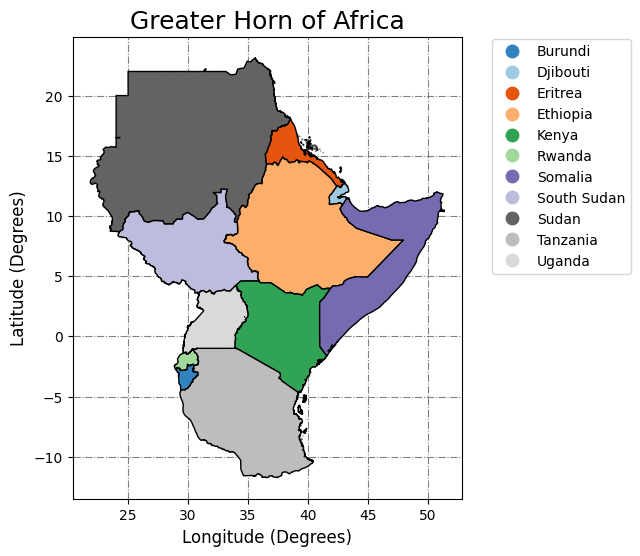

In [171]:
fig, ax = plt.subplots(figsize=(18,6)) 
gha.plot(alpha=1.0, cmap ='tab20c', column='COUNTRY', edgecolor='black', ax=ax, legend=True )
ax.set_title('Greater Horn of Africa', fontsize=18)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashdot')
ax.xaxis.grid(color='gray', linestyle='dashdot')
ax.set_xlabel("Longitude (Degrees)", fontsize=12)
ax.set_ylabel("Latitude (Degrees)", fontsize=12)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.45,1.01))
plt.show()

### Making Subplots

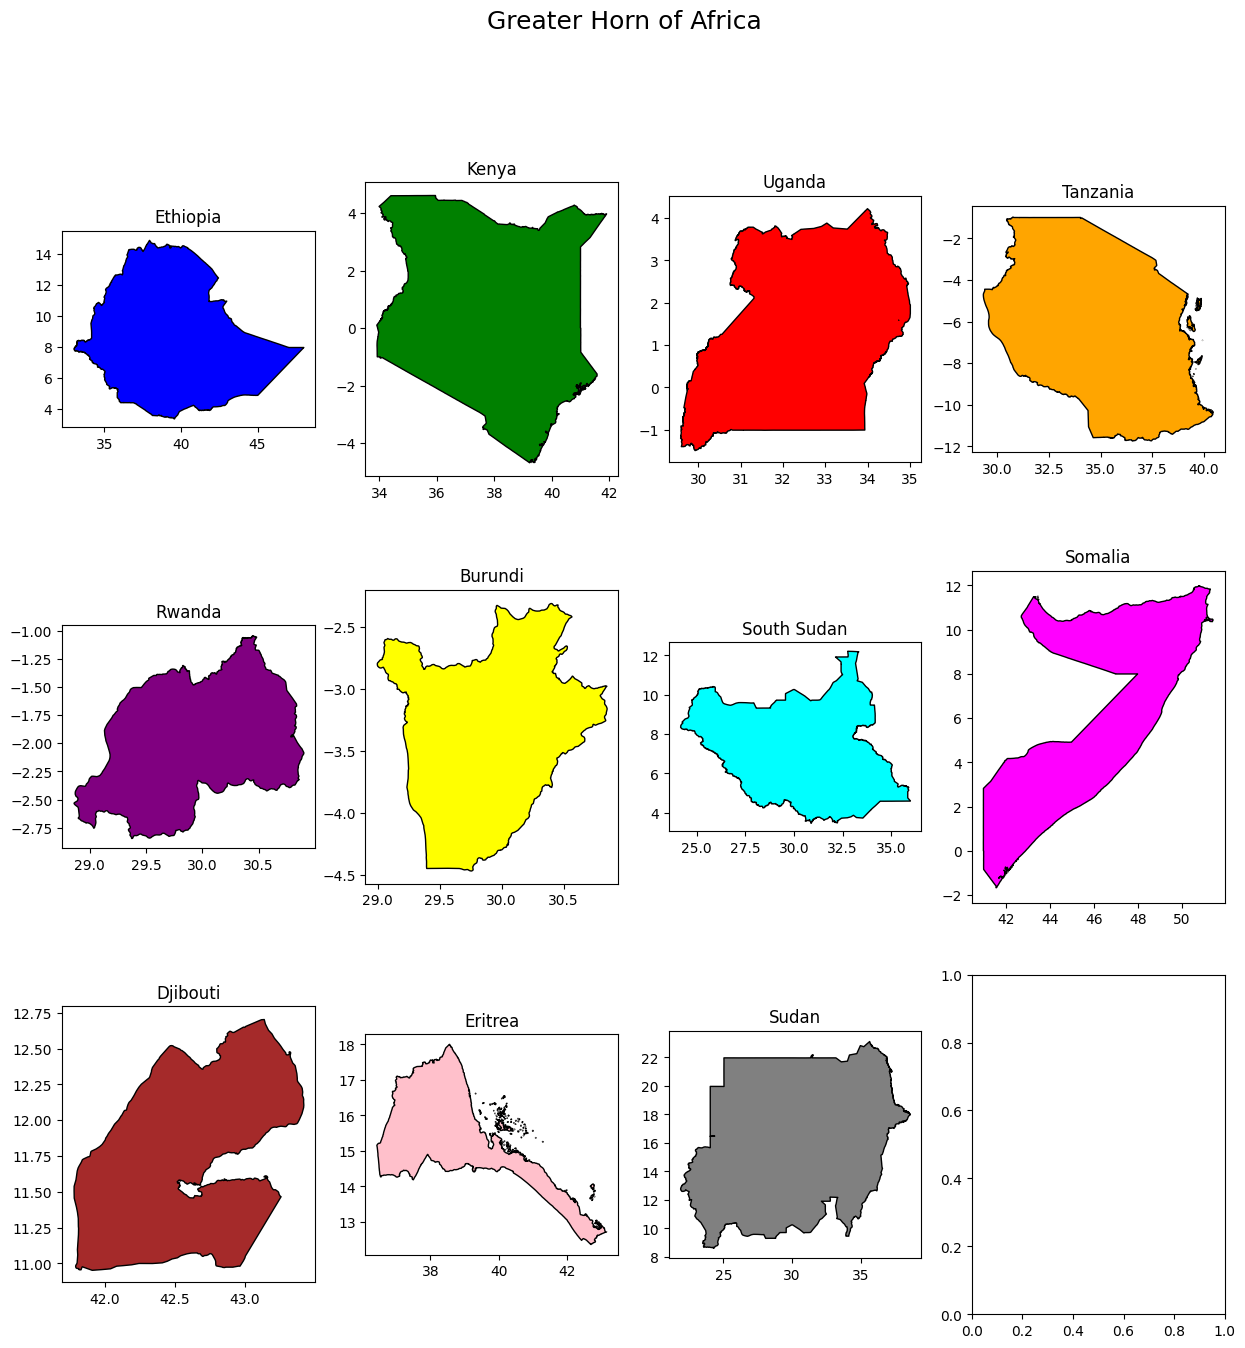

In [176]:
# Making Subplots

fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12)) = plt.subplots(3, 4, figsize=(15,15)) 
fig.suptitle("Greater Horn of Africa", fontsize=18)
gha.loc[gha.COUNTRY == "Ethiopia"].plot(ax=ax1, facecolor='Blue',  edgecolor='black')
ax1.set_title("Ethiopia") 
gha.loc[gha.COUNTRY == "Kenya"].plot(ax=ax2, facecolor='Green',  edgecolor='black')
ax2.set_title("Kenya")
gha.loc[gha.COUNTRY == "Uganda"].plot(ax=ax3, facecolor='Red',  edgecolor='black')
ax3.set_title("Uganda")
gha.loc[gha.COUNTRY == "Tanzania"].plot(ax=ax4, facecolor='Orange',  edgecolor='black')
ax4.set_title("Tanzania")
gha.loc[gha.COUNTRY == "Rwanda"].plot(ax=ax5, facecolor='Purple',  edgecolor='black')
ax5.set_title("Rwanda")
gha.loc[gha.COUNTRY == "Burundi"].plot(ax=ax6, facecolor='Yellow',  edgecolor='black')
ax6.set_title("Burundi")
gha.loc[gha.COUNTRY == "South Sudan"].plot(ax=ax7, facecolor='Cyan',  edgecolor='black')
ax7.set_title("South Sudan")
gha.loc[gha.COUNTRY == "Somalia"].plot(ax=ax8, facecolor='Magenta',  edgecolor='black')
ax8.set_title("Somalia")
gha.loc[gha.COUNTRY == "Djibouti"].plot(ax=ax9, facecolor='Brown',  edgecolor='black')
ax9.set_title("Djibouti")
gha.loc[gha.COUNTRY == "Eritrea"].plot(ax=ax10, facecolor='Pink',  edgecolor='black')
ax10.set_title("Eritrea")
gha.loc[gha.COUNTRY == "Sudan"].plot(ax=ax11, facecolor='Gray',  edgecolor='black')
ax11.set_title("Sudan")
plt.show()

---
### Merge the GeoDataframe   

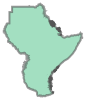

In [183]:
# Merge geometries of all countries into a single geometry

gha_merged = gha.geometry.union_all()
gha_merged


In [ ]:
# Export the merged geometry to a new GeoDataFrame as shapefile

# Convert the multipolygon to a GeoDataFrame
gdf_merged = gpd.GeoDataFrame({'geometry': [gha_merged]}, crs=gha.crs)

# Export the GeoDataFrame to a shapefile
gdf_merged.to_file(f"{processed_data_dir}/gha_merged.shp", driver="ESRI Shapefile")

In [187]:
# from gha select ethiiopia only
et_gha = gha[gha.COUNTRY == "Ethiopia"]
et_gha

,OBJECTID,COUNTRY,area,Shape_Leng,Shape_Area,land_under,geometry
3,4,Ethiopia,0.0,49.028874,92.986294,None,"POLYGON ((41.77824 11.54207, 41.77785 11.51077..."


In [188]:
et_gha.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

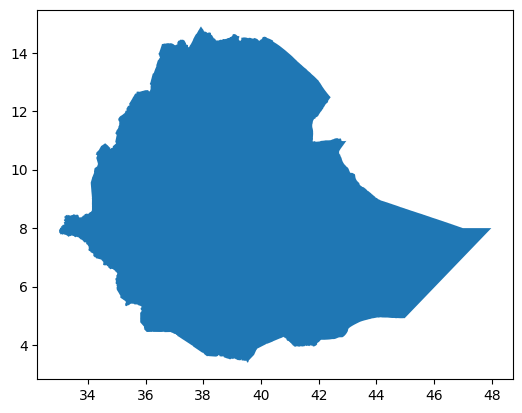

In [193]:
et_gha.plot()

In [ ]:
# et_gha.to_file(f"{processed_data_dir}/et_gha.shp", driver="ESRI Shapefile")

---
## Masking NetCDF with Shapefile [salem] 

In [229]:
tamsat_2019_june = xr.open_dataset("data/raw/tamsat_2019_june.nc")
tamsat_2019_june

<xarray.Dataset> Size: 521kB
Dimensions:  (time: 1, lat: 321, lon: 401)
Coordinates:
  * time     (time) datetime64[ns] 8B 2019-06-01
  * lat      (lat) float64 3kB 15.0 14.96 14.93 14.89 ... 3.113 3.075 3.037 3.0
  * lon      (lon) float64 3kB 33.0 33.04 33.08 33.11 ... 47.89 47.92 47.96 48.0
Data variables:
    rfe      (time, lat, lon) float32 515kB ...
Attributes: (12/13)
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.5
    institution:  TAMSAT Research Group, Meteorology Department, University o...
    title:        TAMSAT Rain Fall Estimate (RFE)
    contact:      tamsat@reading.ac.uk
    history:      Sun Oct 02 19:59:08 2022: cdo enssum rfe2019_06-dk1.v3.nc r...
    ...           ...
    latmax:       15.0
    lonmin:       33.0
    lonmax:       48.0
    latres:       0.0375
    lonres:       0.0375
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

<Axes: >

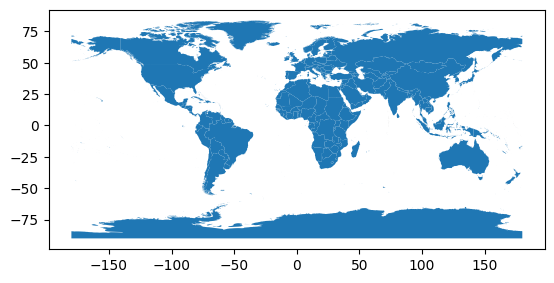

In [216]:
shp_world = salem.read_shapefile(salem.get_demo_file('world_borders.shp'))
shp_world.plot()


<Axes: >

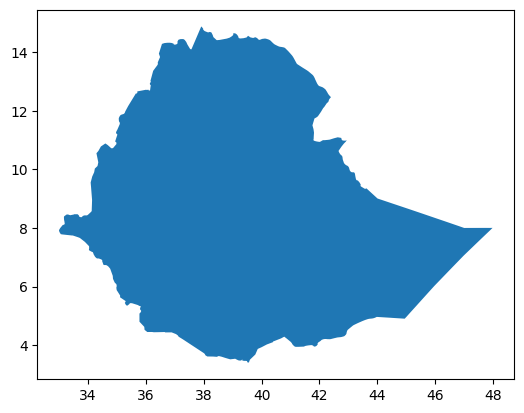

In [194]:
# remove other countries
shp_ethio = shp_world.loc[shp_world['CNTRY_NAME'] == 'Ethiopia'] 
shp_ethio.plot()

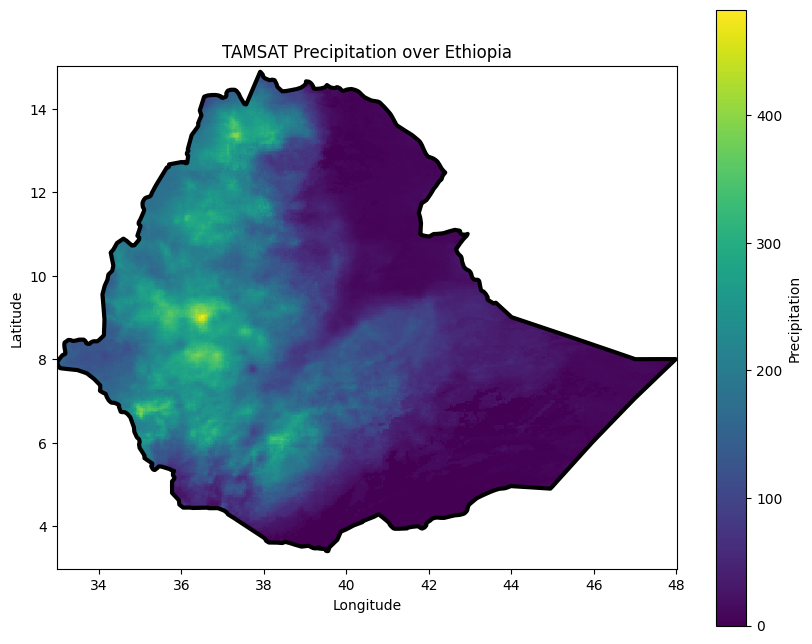

In [230]:
shp_ethio = shp_world.loc[shp_world['CNTRY_NAME'] == 'Ethiopia']
rfe_et = tamsat_2019_june['rfe'].salem.roi(shape=shp_ethio)

fig, ax = plt.subplots(figsize=(10, 8))  # Create figure and axes
rfe_et.isel(time=0).plot(ax=ax, cmap='viridis', cbar_kwargs={'label': 'Precipitation'})
shp_ethio.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=3) 
ax.set_title('TAMSAT Precipitation over Ethiopia')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

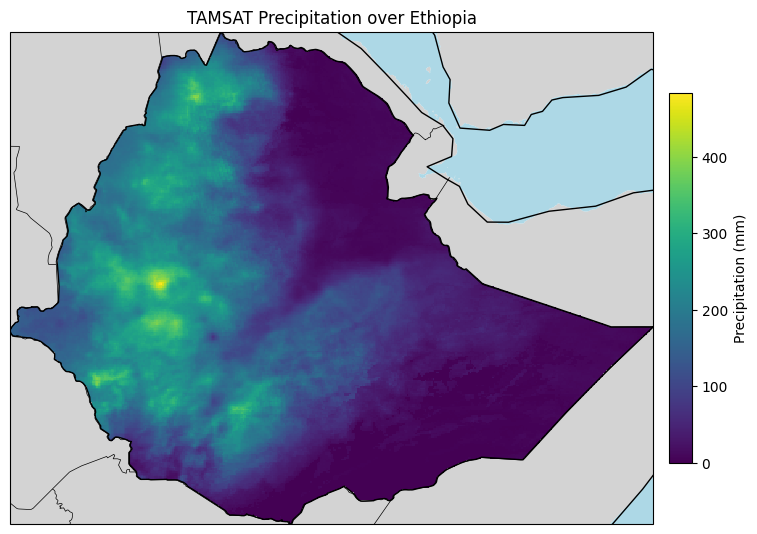

In [ ]:


shp_ethio = shp_world.loc[shp_world['CNTRY_NAME'] == 'Ethiopia']
rfe_et = tamsat_2019_june['rfe'].salem.roi(shape=shp_ethio)

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Add the precipitation data
im = rfe_et.isel(time=0).plot(ax=ax, cmap='viridis', add_colorbar=False)

# Add the country boundary
ax.add_geometries(shp_ethio['geometry'], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1)

# Add coastlines and borders for context
ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Set the title and labels
ax.set_title('TAMSAT Precipitation over Ethiopia')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.02, aspect=16, shrink=0.6)
cbar.set_label('Precipitation (mm)')

# Set the extent of the plot (optional, but recommended)
ax.set_extent([shp_ethio.bounds.minx.min(), shp_ethio.bounds.maxx.max(), shp_ethio.bounds.miny.min(), shp_ethio.bounds.maxy.max()], crs=ccrs.PlateCarree())

plt.show()